## Introduction
In this notebook, we are going to train a machine learning model on a subset of the data and evaluate their performance in correcting the errors.

### Loading needed packages and libraries

In [1]:
!pip install optuna > /dev/null 2>&1

In [2]:
import torch
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import SmoothingFunction
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading the dataset

In [5]:
text_df = pd.read_csv("./moses-martins/Grammar Correction.csv", sep=",")

#### Displaying the first 10 rows of the dataset to understand the data structure and format of the dataset

In [6]:
text_df.head(10)

,Serial Number,Error Type,Ungrammatical Statement,Standard English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.
5,6,Verb Tense Errors,I am eat pizza for lunch.,I am eating pizza for lunch.
6,7,Verb Tense Errors,The students studies for the exam.,The students study for the exam.
7,8,Verb Tense Errors,The car need to be repaired.,The car needs to be repaired.
8,9,Verb Tense Errors,She will goes to the party tonight.,She will go to the party tonight.
9,10,Verb Tense Errors,They watches the movie together.,They watch the movie together.


#### Displaying the shape of the dataset to understand the number of rows and columns in the dataset

Text(0, 0.5, 'Error Type')

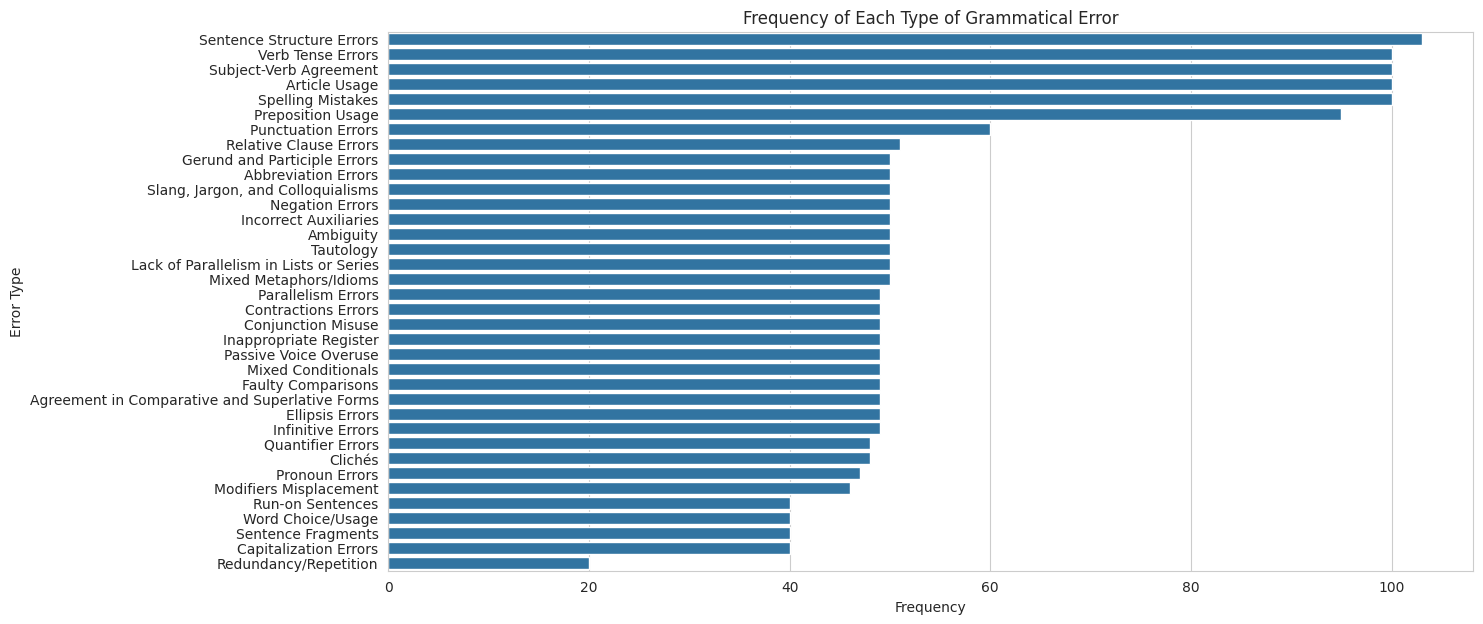

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize = (14, 7))
error_type_plot = sns.countplot(y = text_df["Error Type"], order = text_df["Error Type"].value_counts().index)
error_type_plot.set_title("Frequency of Each Type of Grammatical Error")
error_type_plot.set_xlabel("Frequency")
error_type_plot.set_ylabel("Error Type")

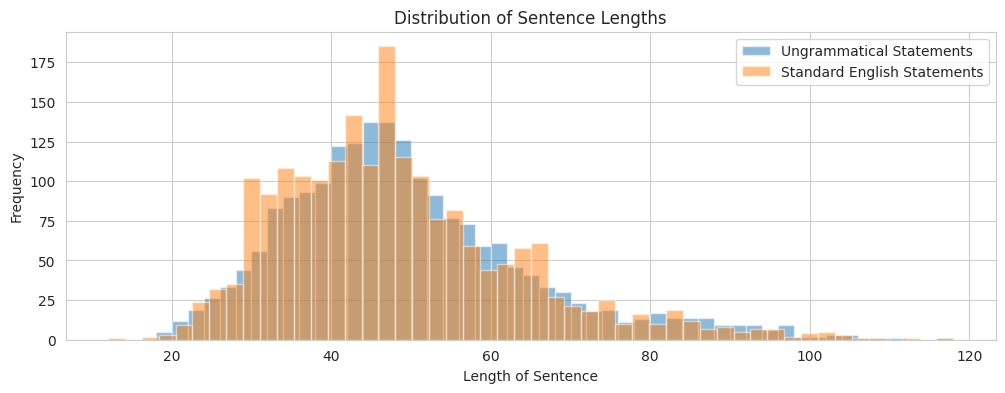

In [8]:
text_df["Ungrammatical Length"] = text_df["Ungrammatical Statement"].apply(len)
text_df["Standard Length"] = text_df["Standard English"].apply(len)

plt.figure(figsize = (12, 4))
plt.hist(text_df["Ungrammatical Length"], bins = 50, alpha = 0.5, label = "Ungrammatical Statements")
plt.hist(text_df["Standard Length"], bins = 50, alpha = 0.5, label = "Standard English Statements")
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Length of Sentence")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Loading pre-trained T5 model and tokenizer from the Hugging Face Transformers library and set the shared parameters

In [9]:
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

for param in model.shared.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#### Define the GrammarCorrectionDataset class for the dataset

In [10]:
class GrammarCorrectionDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        ungrammatical_statement = self.dataframe.iloc[idx]["Ungrammatical Statement"]
        standard_english = self.dataframe.iloc[idx]["Standard English"]
        return ungrammatical_statement, standard_english

#### Splitting the dataset into training, validation, and test sets with 80%, 10%, and 10%

In [11]:
train_df, test_df = train_test_split(text_df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.1)

train_dataset = GrammarCorrectionDataset(train_df)
val_dataset = GrammarCorrectionDataset(val_df)
test_dataset = GrammarCorrectionDataset(test_df)

In [12]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)

#### Define the **train_epoch** function to train the model

In [13]:
def train_epoch(model, dataloader, optimizer, device, scheduler):
    model = model.to(device)
    model.train()
    total_loss = 0
    for ungrammatical_statement, standard_english in dataloader:
        inputs = tokenizer(ungrammatical_statement, return_tensors = "pt", padding = True, truncation=True, max_length = 256).to(device)
        labels = tokenizer(standard_english, return_tensors = "pt", padding = True, truncation = True, max_length = 256).input_ids.to(device)
        outputs = model(**inputs, labels = labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    average_loss = total_loss / len(dataloader)
    return average_loss

#### Define the **eval_model** function to evaluate the model on the validation or test set

In [14]:
def eval_model(model, dataloader, device):
    model = model.to(device)
    model.eval()
    total_bleu_score = 0
    smoothing = SmoothingFunction().method1
    with torch.no_grad():
        for ungrammatical_statement, standard_english in dataloader:
            inputs = tokenizer(ungrammatical_statement, return_tensors = "pt", padding = True, truncation = True, max_length = 256).to(device)
            labels = tokenizer(standard_english, return_tensors = "pt", padding = True, truncation = True, max_length = 256).input_ids.to(device)
            outputs = model.generate(**inputs, max_new_tokens = 256)
            corrected_english = tokenizer.decode(outputs[0], skip_special_tokens = True)
            reference = [standard_english[0].split()]
            candidate = corrected_english.split()
            bleu_score = sentence_bleu(reference, candidate, smoothing_function = smoothing)
            total_bleu_score += bleu_score
    average_bleu_score = total_bleu_score / len(dataloader)
    print(average_bleu_score)
    return average_bleu_score

In [15]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 5)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    for param in model.shared.parameters():
        param.requires_grad = False

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)

    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

    for epoch in range(num_train_epochs):
        average_loss = train_epoch(model, train_dataloader, optimizer, device, scheduler)
        print(f"Epoch: {epoch+1}, Loss: {average_loss}")
        eval_model(model, val_dataloader, device)

    average_bleu_score = eval_model(model, test_dataloader, device)
    return average_bleu_score

study = optuna.create_study(direction = "maximize", pruner = optuna.pruners.MedianPruner())
study.optimize(objective, n_trials = 5)
print(study.best_params)

[I 2024-09-12 06:05:17,338] A new study created in memory with name: no-name-b62c40b8-3cc6-4c2d-9254-5dc1f0a98045


Epoch: 1, Loss: 5.483549522316975
0.4846861119473533
Epoch: 2, Loss: 4.1908571564632915
0.42520257762678143
Epoch: 3, Loss: 4.023933612782022
0.3493579787117725


[I 2024-09-12 06:07:06,958] Trial 0 finished with value: 0.4597416767977652 and parameters: {'learning_rate': 7.10178174544239e-06, 'num_train_epochs': 3, 'batch_size': 32}. Best is trial 0 with value: 0.4597416767977652.


0.4597416767977652
Epoch: 1, Loss: 0.8743357569961757
0.8523781126477122
Epoch: 2, Loss: 0.21095251840549512
0.8686873664211603


[I 2024-09-12 06:08:06,898] Trial 1 finished with value: 0.6029247605117536 and parameters: {'learning_rate': 8.994687313339029e-05, 'num_train_epochs': 2, 'batch_size': 16}. Best is trial 1 with value: 0.6029247605117536.


0.6029247605117536
Epoch: 1, Loss: 1.4959203069696085
0.46418459443534876
Epoch: 2, Loss: 0.47727590998424313
0.5604237733740624
Epoch: 3, Loss: 0.45743177644395305
0.4849562888738801
Epoch: 4, Loss: 0.4587097864177273
0.49072454288000694
Epoch: 5, Loss: 0.47025160417576467
0.5801317004990454


[I 2024-09-12 06:15:18,394] Trial 2 finished with value: 0.570890147086988 and parameters: {'learning_rate': 1.1122068222868935e-05, 'num_train_epochs': 5, 'batch_size': 4}. Best is trial 1 with value: 0.6029247605117536.


0.570890147086988
Epoch: 1, Loss: 6.233076769372691
0.4548113990132132
Epoch: 2, Loss: 5.947113876757414
0.5772748344528235
Epoch: 3, Loss: 5.85002324892127
0.3784349745549847
Epoch: 4, Loss: 5.817770450011544
0.38784425588221527
Epoch: 5, Loss: 5.881670703058657
0.532036915718354


[I 2024-09-12 06:17:44,055] Trial 3 finished with value: 0.4360482578509851 and parameters: {'learning_rate': 1.9404791423602014e-06, 'num_train_epochs': 5, 'batch_size': 32}. Best is trial 1 with value: 0.6029247605117536.


0.4360482578509851
Epoch: 1, Loss: 5.522340448006339
0.3582628183500975


[I 2024-09-12 06:18:39,222] Trial 4 finished with value: 0.3669683102311756 and parameters: {'learning_rate': 6.172847238160839e-06, 'num_train_epochs': 1, 'batch_size': 32}. Best is trial 1 with value: 0.6029247605117536.


0.3669683102311756
{'learning_rate': 8.994687313339029e-05, 'num_train_epochs': 2, 'batch_size': 16}


#### Loading the pre-trained T5 model and tokenizer

In [16]:
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

for param in model.shared.parameters():
    param.requires_grad = False

model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

#### Getting the best hyperparameters from the study

In [17]:
learning_rate = study.best_params["learning_rate"]
num_train_epochs = study.best_params["num_train_epochs"]
per_device_train_batch_size = study.best_params["batch_size"]

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)

train_dataloader = DataLoader(train_dataset, batch_size = per_device_train_batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = per_device_train_batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = per_device_train_batch_size, shuffle = True)

for epoch in range(num_train_epochs):
    average_loss = train_epoch(model, train_dataloader, optimizer, device, scheduler)
    print(f"Epoch: {epoch+1}, Loss: {average_loss}")
    eval_model(model, val_dataloader, device)

eval_model(model, test_dataloader, device)

Epoch: 1, Loss: 0.8334637294103812
0.7040533054035563
Epoch: 2, Loss: 0.19972551540359035
0.6535169581859944
0.7123996875022574


0.7123996875022574

#### Implement the fine-tuned model on the dataset to correct the ungrammatical statements

In [18]:
def correct_grammar(model, ungrammatical_statement):
    model.eval()
    inputs = tokenizer(ungrammatical_statement, return_tensors = "pt", padding = True, truncation = True, max_length = 256).to(device)
    outputs = model.generate(**inputs, max_new_tokens = 256)
    corrected_english = tokenizer.decode(outputs[0], skip_special_tokens = True)
    return corrected_english

text_df["Corrected English"] = text_df["Ungrammatical Statement"].apply(lambda x: correct_grammar(model, x))

In [19]:
text_df.head(20)

,Serial Number,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length,Corrected English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.,29,27,I go to the store every day.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.,35,36,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.,32,31,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.,25,27,He doesn't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.,25,26,The sun rises in the east.
5,6,Verb Tense Errors,I am eat pizza for lunch.,I am eating pizza for lunch.,25,28,I am eating pizza for lunch.
6,7,Verb Tense Errors,The students studies for the exam.,The students study for the exam.,34,32,The students study for the exam.
7,8,Verb Tense Errors,The car need to be repaired.,The car needs to be repaired.,28,29,The car needs to be repaired.
8,9,Verb Tense Errors,She will goes to the party tonight.,She will go to the party tonight.,35,33,She will go to the party tonight.
9,10,Verb Tense Errors,They watches the movie together.,They watch the movie together.,32,30,They watch the movie together.


In [20]:
text_df.tail(20)

,Serial Number,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length,Corrected English
1998,1999,Lack of Parallelism in Lists or Series,"The store offers a wide range of products, com...","The store offers a wide range of products, com...",105,103,"The store offers a wide range of products, com..."
1999,2000,Lack of Parallelism in Lists or Series,"The vacation package includes flights, accommo...","The vacation package includes flights, accommo...",80,78,"The vacation package includes flights, accommo..."
2000,2001,Lack of Parallelism in Lists or Series,"The manager expects employees to be punctual, ...","The manager expects employees to be punctual, ...",84,81,"The manager expects employees to be punctual, ..."
2001,2002,Lack of Parallelism in Lists or Series,"The strategy involves analyzing market trends,...","The strategy involves analyzing market trends,...",102,102,"The strategy involves analyzing market trends,..."
2002,2003,Lack of Parallelism in Lists or Series,"The event will feature live music, delicious f...","The event will feature live music, delicious f...",82,79,"The event will feature live music, delicious f..."
2003,2004,Lack of Parallelism in Lists or Series,The article discusses the importance of educat...,The article discusses the importance of educat...,103,102,The article discusses the importance of educat...
2004,2005,Lack of Parallelism in Lists or Series,"The exercise routine includes stretching, stre...","The exercise routine includes stretching, stre...",88,82,"The exercise routine includes stretching, stre..."
2005,2006,Lack of Parallelism in Lists or Series,The government is committed to reducing povert...,The government is committed to reducing povert...,104,103,The government is committed to reducing povert...
2006,2007,Lack of Parallelism in Lists or Series,"The app allows users to track their expenses, ...","The app allows users to track their expenses, ...",89,86,"The app allows users to track their expenses, ..."
2007,2008,Lack of Parallelism in Lists or Series,"The exhibition showcases contemporary art, pho...","The exhibition showcases contemporary art, pho...",84,82,"The exhibition showcases contemporary art, pho..."


### Conclusion
After training the machine learning model on the dataset subset, we evaluated the effectiveness in correcting grammatical errors. The performance offers valuable insights for further refinement and development of grammar correction systems.